# Setup

In [2]:
import pickle
from model import ChessNet
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset import *
from utils import *

In [3]:
TEST_SEGMENT = 'below_1450'

In [4]:
test_samples = read_data_sample(f"data/test_{TEST_SEGMENT}_15kCUTOFF.pkl")
len(test_samples)

167298

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
# get the move from argmax of the predicted distribution
def argmax_move(batch: torch.Tensor, topk=1):
    sort_idx = torch.argsort(batch, dim=1, descending=True)
    pred_y = torch.zeros_like(batch)

    for i in range(topk):
        pred_y.scatter_(1, sort_idx[:, i : i + 1], 1)

    return pred_y.to(device)


# sample the move from the predicted distribution
def sample_move(batch: torch.Tensor):
    pred_y = torch.zeros_like(batch)
    for i in range(batch.shape[0]):
        move = torch.multinomial(batch[i], 1)
        pred_y[i, move] = 1

    return pred_y.to(device)


def eval(model, dl, topk=1):
    model.eval()
    total = 0
    correct = 0

    for idx, (x, y) in enumerate(tqdm(dl)):
        x, y = x.to(device), y.to(device)
        output = model(x)

        pred_y = argmax_move(output)
        correct += (pred_y == y).all(dim=1).sum().item()
        total += y.size(0)

    return correct / total

In [127]:
piece = 'q'
checkpoint = f'{piece}_c14_relu_epc15_batsize256_lr0.003'
# checkpoint = 'relu_epc15_batsize256_lr0.003'

# Loss history

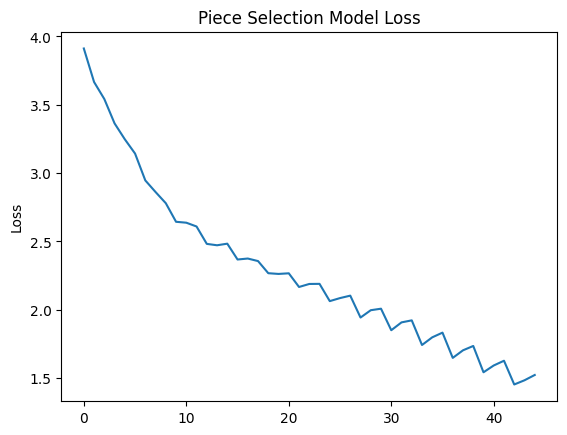

In [128]:
with open(f"log/{TEST_SEGMENT}/{checkpoint}.log", "rb") as f:
    loss_hist = pickle.load(f)

# plot loss history
plt.plot(loss_hist)
plt.ylabel("Loss")
plt.title("Piece Selection Model Loss")
plt.show()

# Move selection

In [129]:
test_samples = filter_by_piece(test_samples, piece)
len(test_samples)

23995

In [130]:
model = ChessNet(
    num_classes=64,
    num_channels=14,
    activation=nn.ReLU(inplace=True),
).to(device)

model.load_state_dict(torch.load(f"checkpoint/{TEST_SEGMENT}/move_selection/{checkpoint}.ckpt"))

<All keys matched successfully>

In [131]:
# test_samples_ds = PieceSelectionGroupedDataset(test_samples)
test_ds = ChessDataset(test_samples, mask_move=True, add_legal_moves=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [132]:
print(f'Accuracy on {piece}: {eval(model, test_dl)*100:.3f}%')

100%|██████████| 94/94 [00:13<00:00,  6.93it/s]

Accuracy on q: 47.614%


# Piece selection

In [ ]:
model = ChessNet(
    num_classes=64,
    num_channels=13,
    activation=nn.ReLU(inplace=True),
).to(device)

model.load_state_dict(torch.load(f"checkpoint/{TEST_SEGMENT}/piece_selection/{checkpoint}.ckpt"))

In [16]:
# test_samples_ds = PieceSelectionGroupedDataset(test_samples)
test_ds = ChessDataset(test_samples, add_legal_moves=True)
test_dl = DataLoader(test_ds, batch_size=512, shuffle=False)

In [17]:
print(f'Accuracy of piece selection model: {eval(model, test_dl)*100:.3f}%')

100%|██████████| 44/44 [00:08<00:00,  4.89it/s]

Accuracy of piece selection model: 52.457%


# Result

### Above 1800

- Move selection(15ep - relu - lr0.003 - batsize256 - 14 channel encoding)
    - Acc@1
        - Pawn: 88.273%
        - King: 71.578%
        - Queen: 46.004%
        - Rock: 55.583%
        - Bishop: 65.647%
        - Knight: 72.058%
    - Acc@3: 
        - Pawn: 99.857%
        - King: 92.466%
        - Queen: 63.090%
        - Rock: 73.777%
        - Bishop: 85.925%
        - Knight: 91.969%
    - Acc@5: 
        - Pawn: 99.974%
        - King: 96.436%
        - Queen: 70.876%
        - Rock: 81.576%
        - Bishop: 91.538%
        - Knight: 96.414%
- Piece selection:
    - Acc@1: 37.022%
    - Acc@3: 56.849%
    - Acc@5: 64.951%